
<h2>Target</h2>
<ul>
<li>Generative (not retrieval)</li>
<li>Small-talk (short convos)</li>
<li>Open Domain</li>
<li>No context</li>
<li>Eval [https://arxiv.org/abs/1603.08023]</li>
</ul>
<h2>Potential Sources of Data</h2>
<ul>
<li>http://files.pushshift.io/reddit/comments/</li>
<li>https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html</li>
<li>https://github.com/Marsan-Ma/twitter_scraper</li>
<li>http://dataset.cs.mcgill.ca/ubuntu-corpus-1.0/</li>
</ul>
<h2>Potential Models</h2>
<h3>This Medium Article</h3>
<ul>
<li>https://medium.com/botsupply/generative-model-chatbots-e422ab08461e</li>
<li>Use high LR, then reduce</li>
<li>Reverse input sentence</li>
<li>50 K vocab</li>
</ul>
<h3>LSTM Encoder Decoder</h3>
<h2></h2>

In [5]:
%cd ..
%cd root
import pandas as pd
df = pd.read_csv("dwdata_2.csv")
df.fillna('', inplace=True)

/
/root


In [14]:
x_1 = df["X_1"].tolist()
y_1 = df["Y_1"].tolist()

import tensorflow_datasets as tfds
# from tensorflow_datasets.features.text.SubwordTextEncoder import build_from_corpus
from tensorflow.keras.preprocessing.sequence import pad_sequences
token_x = tfds.features.text.SubwordTextEncoder.build_from_corpus(x_1, target_vocab_size=1e12)
token_y = tfds.features.text.SubwordTextEncoder.build_from_corpus(y_1, target_vocab_size=1e12)

vocab_size_x = token_x.vocab_size
vocab_size_y = token_y.vocab_size + 2 # adding the start and end characters

inputs = [token_x.encode(sentence) for sentence in x_1]
outputs = [[vocab_size_y - 2] + token_y.encode(sentence) + [vocab_size_y - 1] for sentence in y_1]

MAXLEN = 70
idx_to_shorten = [count for count, sent in enumerate(inputs) if len(sent) > MAXLEN]
for idx in idx_to_shorten:
    inputs[idx] = inputs[idx][:MAXLEN]
    outputs[idx] = outputs[idx][:MAXLEN]
idx_to_shorten = []
idx_to_shorten = [count for count, sent in enumerate(outputs) if len(sent) > MAXLEN]
for idx in idx_to_shorten:
    inputs[idx] = inputs[idx][:MAXLEN]
    outputs[idx] = outputs[idx][:MAXLEN]

MINLEN = 4
idx_to_delete = [count for count, sent in enumerate(inputs) if len(sent) < MINLEN]
for idx in reversed(idx_to_delete):
    del inputs[idx]
    del outputs[idx]
idx_to_delete = []
idx_to_delete = [count for count, sent in enumerate(outputs) if len(sent) < MINLEN]
for idx in reversed(idx_to_delete):
    del inputs[idx]
    del outputs[idx]

inputs = pad_sequences(inputs, value=0, padding="post", maxlen=MAXLEN)
outputs = pad_sequences(outputs, value=0, padding="post", maxlen=MAXLEN)
print("{},{}".format(inputs.shape,outputs.shape))

(21771, 70),(21771, 70)


In [17]:
import numpy as np
from scipy.ndimage.interpolation import shift
inputs_1 = inputs
inputs_2 = outputs
outputs_1 = outputs
outputs_1 = shift(outputs_1, [0,-1], cval=0)
print("{},{}".format(inputs_1.shape,outputs_1.shape))

(21771, 70),(21771, 70)


In [18]:
print(inputs_1[20,:20])
print(inputs_2[20,:20])
print(outputs_1[20,:20])

[  22    7   23  672   95 3744   16   41  418    3   35  274   49    0
    0    0    0    0    0    0]
[27074    22    14   809    28     4 10094   255  1314    31     4   423
    67     5  1448   608     3    90     5   365]
[   22    14   809    28     4 10094   255  1314    31     4   423    67
     5  1448   608     3    90     5   365  2681]


In [0]:
inputs_1 = np.expand_dims(inputs_1,axis=-1)
inputs_2 = np.expand_dims(inputs_2,axis=-1)
outputs_1 = np.expand_dims(outputs_1,axis=-1)

In [23]:
import numpy as np
print(token_x.decode(np.squeeze(inputs_1[0],axis=-1)))

im pleased you two are so impressed i find the whole placehateful


In [0]:
latent_dim = 256
batch_size = 32
epochs = 100

In [25]:
print("{},{}".format(vocab_size_x,vocab_size_y))

22801,27076


In [29]:
#We do the most basic one
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.optimizers import Adam
encoder_inputs = Input(shape=(None,1))
encoder_outputs, state_h, state_c = LSTM(latent_dim, return_state=True)(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None,1))
decoder_outputs, _, _ = LSTM(latent_dim, return_sequences=True, return_state=True)(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(1, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

adam = Adam(lr=0.1, decay=1e-6)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit([inputs_1, inputs_2], outputs_1,batch_size=batch_size,epochs=epochs,validation_split=0.2)
model.save("2nd_m.h5")

Epoch 1/100
545/545 [==============================] - 10s 18ms/step - loss: 7.9333e-05 - accuracy: 0.0068 - val_loss: 8.0460e-05 - val_accuracy: 0.0071
Epoch 2/100
545/545 [==============================] - 9s 16ms/step - loss: 7.9330e-05 - accuracy: 0.0068 - val_loss: 8.0460e-05 - val_accuracy: 0.0071
Epoch 3/100
545/545 [==============================] - 9s 16ms/step - loss: 7.9322e-05 - accuracy: 0.0068 - val_loss: 8.0460e-05 - val_accuracy: 0.0071
Epoch 4/100
545/545 [==============================] - 9s 16ms/step - loss: 7.9328e-05 - accuracy: 0.0068 - val_loss: 8.0460e-05 - val_accuracy: 0.0071
Epoch 5/100
545/545 [==============================] - 9s 16ms/step - loss: 7.9351e-05 - accuracy: 0.0068 - val_loss: 8.0460e-05 - val_accuracy: 0.0071
Epoch 6/100
545/545 [==============================] - 9s 16ms/step - loss: 7.9338e-05 - accuracy: 0.0068 - val_loss: 8.0460e-05 - val_accuracy: 0.0071
Epoch 7/100
545/545 [==============================] - 9s 16ms/step - loss: 7.9339e-05 

The model might have a case of vanishing gradient problem, and it's underfitting (plateauing loss) --> increase cells / increase layers

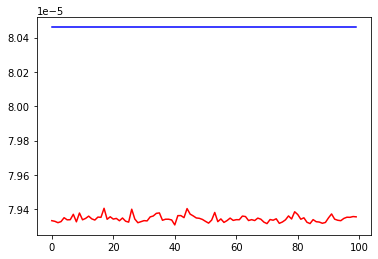

In [30]:
import matplotlib.pyplot as plt
plt.plot(hist.history["loss"], color="r")
plt.plot(hist.history["val_loss"], color="b")

In [0]:
encoder_model = Model(encoder_inputs, encoder_states)
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = LSTM(latent_dim, return_sequences=True, return_state=True)(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,[decoder_outputs] + decoder_states)

In [32]:
def decode_sequence(input_seq):
    input_seq = np.expand_dims(input_seq,axis=-1)
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1,1,1))
    target_seq[0, 0, 0] = vocab_size_y - 2

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = []
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sampled_token_index = output_tokens[:,-1,:]
        decoded_sentence.append(sampled_token_index[0][0])

        if (sampled_token_index == vocab_size_y - 1 or len(decoded_sentence) > MAXLEN):
            stop_condition = True

        target_seq = np.zeros((1,1,1))
        target_seq[0,0,0] = sampled_token_index
        states_value = [h, c]
    pred = token_y.decode([int(i) for i in decoded_sentence])
    return pred
index_try = 33
input_seq = inputs_1[index_try: index_try + 1]
pred = decode_sequence(input_seq)
print('-')
print('Input sentence:', token_x.decode(np.squeeze(inputs_1[index_try], axis=-1)))
print('Decoded sentence:', pred)

-
Input sentence: ill just fetch my galoshes
Decoded sentence: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


I can't really tell whether the model sucks or the prediction sucks, but I am going to add an embedding layer in between to help //
https://github.com/keras-team/keras/blob/master/examples/lstm_seq2seq.py